# Annual reports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [17]:
daily_return = pd.read_csv("../database/mergedData/Annual_AVG_RET.csv", index_col=[0])
report_value = pd.read_csv("../database/mergedData/Annual_V.csv", index_col=[0])

In [18]:
daily_return = daily_return.dropna()
report_value = report_value.dropna()

### Cast to quasi logarithmic differential model

In [19]:
# Function cast report in value -> diff in quasi log scale
def castToDiffQuasiLog(report_value : pd.DataFrame) -> pd.DataFrame: 
    QUASI_LOG_VALUE = 1e-6
    new_index = report_value.index.to_numpy()[1:] # Without first row
    reports_np =  report_value.to_numpy()
    log_value = np.vectorize(lambda x : np.log10(np.max([x, QUASI_LOG_VALUE])))(reports_np[:,2:])
    log_diff = log_value[1:] - log_value[:-1]
    reports_np = reports_np[1:]
    reports_np[:, 2:] = log_diff
    return pd.DataFrame(data=reports_np, 
                        columns=report_value.columns, 
                        index=new_index)


#Prepare data frame 
log_diff_database = pd.DataFrame(columns=report_value.columns)

# For all tickers 
tickers = report_value["Ticker"].unique()
for ticker in tickers:
    company_data = report_value[report_value["Ticker"] == ticker]
    company_log_diff = castToDiffQuasiLog(company_data)
    log_diff_database = pd.concat([log_diff_database, company_log_diff], ignore_index=False)

## Prepare data to learn

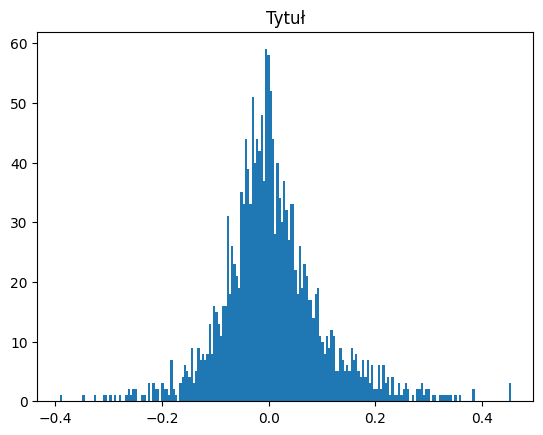

In [73]:
database = pd.concat([log_diff_database, daily_return], axis=1, join="inner") #TODO cahange report_value -> log_diff_database
numeric_target = database["AVG_14D"].to_numpy()
up_bound = numeric_target.mean() + 3 * numeric_target.std()
down_bound = numeric_target.mean() - 3 * numeric_target.std()
numeric_target_3s = numeric_target[np.logical_and(numeric_target > down_bound, numeric_target < up_bound)]
counts, bins = np.histogram(numeric_target_3s, bins=200)
plt.stairs(counts, bins, fill=True)
plt.title("Tytuł")
plt.show()

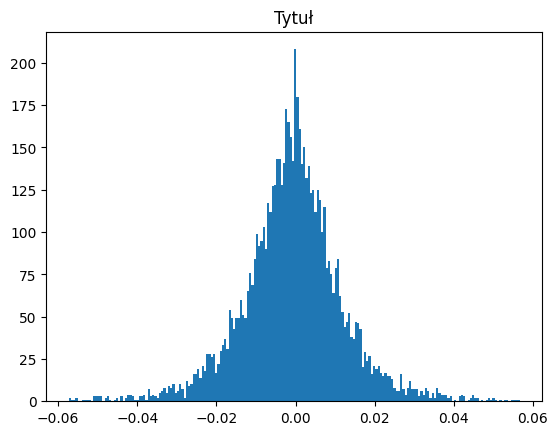

In [5]:
# Connect database to target 
database = pd.concat([report_value, daily_return], axis=1, join="inner") #TODO cahange report_value -> log_diff_database
numeric_target = (database["Post14D"]-database["Pre14D"]).to_numpy()
up_bound = numeric_target.mean() + 3 * numeric_target.std()
down_bound = numeric_target.mean() - 3 * numeric_target.std()
numeric_target_3s = numeric_target[np.logical_and(numeric_target > down_bound, numeric_target < up_bound)]
counts, bins = np.histogram(numeric_target_3s, bins=200)
plt.stairs(counts, bins, fill=True)
plt.title("Tytuł")
plt.show()

In [132]:
from sklearn.model_selection import train_test_split

#Remove correlated data 
correlated_columns = [
 'Amortyzacja', 
 'Zysk operacyjny (EBIT)', 
 'Zysk z działalności gospodarczej',
 'Zysk przed opodatkowaniem',
 'Zysk netto akcjonariuszy jednostki dominującej',
 'Środki pieniężne i inne aktywa pieniężne',
 'Aktywa razem',
 'Pasywa razem', #For > 0.7
 'Techniczny koszt wytworzenia produkcji sprzedanej',
 'Wynik zdarzeń nadzwyczajnych',
 'Rzeczowe składniki majątku trwałego' # For > 0.6
  ]

# Arbitrary categorization 
y = pd.cut(np.array(numeric_target), bins=[-np.inf, 0, np.inf], labels=[-1, 1]).to_numpy()
x = database.drop(columns=correlated_columns)
x = x[selected].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
np.unique(y, return_counts=True)

(array([-1,  1]), array([912, 885]))

In [133]:
from sklearn.preprocessing import StandardScaler
transformer = StandardScaler().fit(X_train)
X_train_std = transformer.transform(X_train)
X_test_std = transformer.transform(X_test)

In [134]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

clf = RandomForestClassifier(n_estimators=1000, max_depth=6, n_jobs=-1)
clf.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=6, n_estimators=1000, n_jobs=-1)

In [135]:
y_pred = clf.predict(X_test_std)

In [136]:
np.unique(y_test, return_counts=True)

(array([-1,  1]), array([308, 286]))

In [137]:
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([291, 303]))

In [138]:
x = database.drop(columns=correlated_columns)
x.shape

(1797, 48)

Accuracy (Dokładność): 56.06%
Precision (Precyzja): 56.17%
Recall (Czułość): 56.06%
F1 Score: 56.07%

Raport klasyfikacji:

              precision    recall  f1-score   support

          -1       0.58      0.55      0.56       308
           1       0.54      0.57      0.56       286

    accuracy                           0.56       594
   macro avg       0.56      0.56      0.56       594
weighted avg       0.56      0.56      0.56       594



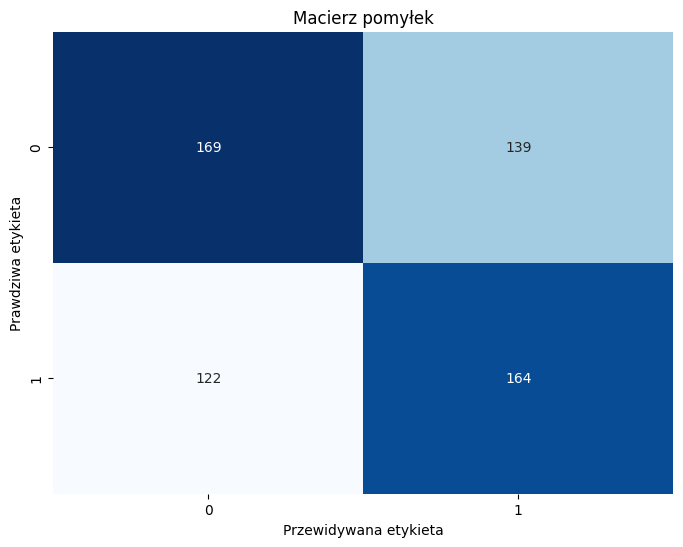

In [140]:
evaluate_classifier(y_test, y_pred)

In [129]:
selected = ["Zysk netto",                                         
"Przepływy pieniężne z działalności finansowej",        
"Zapasy",                                           
"Pozostałe aktywa trwałe",                               
"Aktywa obrotowe",                                       
"Kapitał własny akcjonariuszy jednostki dominującej",   
"Zysk (strata) netto z działalności zaniechanej",        
"Należności długoterminowe",                             
"Koszty ogólnego zarządu",                              
"Kapitał (fundusz) podstawowy",                          
"Zysk ze sprzedaży",                                     
"Zobowiązania z tytułu leasingu finansowego",            
"Udziały niekontrolujące",                               
"Kredyty i pożyczki",                                    
"Inwestycje długoterminowe",                             
"Zobowiązania długoterminowe",                           
"Pozostałe przychody operacyjne",                        
"Udziały (akcje) własne",  
]                            

In [123]:
from sklearn.feature_selection import mutual_info_classif

x = database.drop(columns=correlated_columns)
importances = mutual_info_classif(X_train_std, y_train)
 
feature_info = pd.Series(importances, x.columns.to_numpy()[2:-6]).sort_values(ascending=False)
feature_info


Zysk netto                                            0.041252
Przepływy pieniężne z działalności finansowej         0.028947
Zapasy                                                0.028419
Pozostałe aktywa trwałe                               0.021815
Aktywa obrotowe                                       0.020995
Kapitał własny akcjonariuszy jednostki dominującej    0.020462
Zysk (strata) netto z działalności zaniechanej        0.020130
Należności długoterminowe                             0.013990
Koszty ogólnego zarządu                               0.013182
Kapitał (fundusz) podstawowy                          0.011926
Zysk ze sprzedaży                                     0.011777
Zobowiązania z tytułu leasingu finansowego            0.010008
Udziały niekontrolujące                               0.005951
Kredyty i pożyczki                                    0.005745
Inwestycje długoterminowe                             0.005584
Zobowiązania długoterminowe                           0

Accuracy (Dokładność): 35.35%
Precision (Precyzja): 28.97%
Recall (Czułość): 35.35%
F1 Score: 29.29%

Raport klasyfikacji:

              precision    recall  f1-score   support

          -1       0.37      0.32      0.34       211
           0       0.12      0.02      0.03       179
           1       0.36      0.69      0.48       204

    accuracy                           0.35       594
   macro avg       0.28      0.34      0.28       594
weighted avg       0.29      0.35      0.29       594



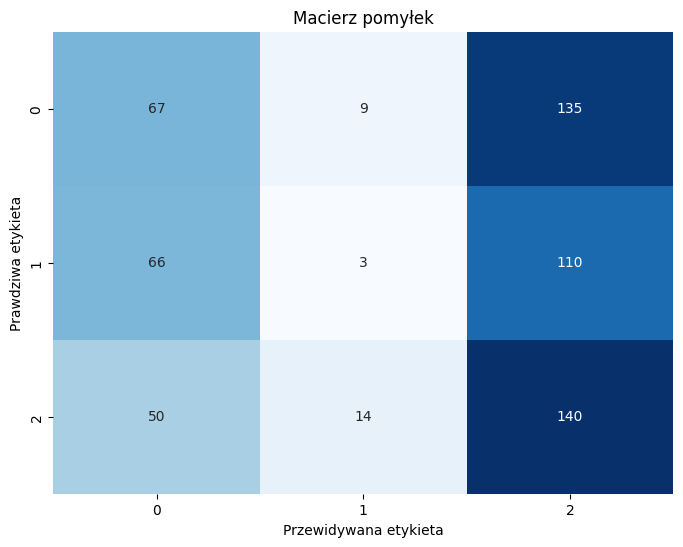

In [84]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
pca.fit(X_train_std)
x_train_pca = pca.transform(X_train_std)
x_test_pca = pca.transform(X_test_std)

clf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
clf.fit(x_train_pca, y_train)

y_pred = clf.predict(x_test_pca)

evaluate_classifier(y_test, y_pred)

In [316]:
import seaborn as sb

x_train_df = pd.DataFrame(X_train, columns=database.columns.to_numpy()[2:-6])
corr = x_train_df.corr()

In [383]:
list_corelation = []

ccorr = x_train_df.drop(columns=col_to_drop)

ccorr = ccorr.corr()

x = ccorr.where(ccorr.abs() > 0.6).to_numpy()
for i, row in enumerate(x):
    for j, value in enumerate(row):
        if not (np.isnan(value) or value == 1.) :
            pair = [name[i], name[j]]
            list_corelation.append(pair)


In [384]:
x_train_df_after_corr = x_train_df.drop(columns=col_to_drop)

In [398]:

print(pca.explained_variance_ratio_)

[0.20612805 0.13860657 0.09620376 0.06960783 0.05202406 0.04623293
 0.03931589 0.03743122 0.03542049 0.02799745 0.02526078 0.02312517
 0.0216822  0.02129242]


Accuracy (Dokładność): 70.00%
Precision (Precyzja): 70.00%
Recall (Czułość): 70.00%
F1 Score: 70.00%

Raport klasyfikacji:

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         4
           1       0.67      0.67      0.67         3
           2       0.67      0.67      0.67         3

    accuracy                           0.70        10
   macro avg       0.69      0.69      0.69        10
weighted avg       0.70      0.70      0.70        10



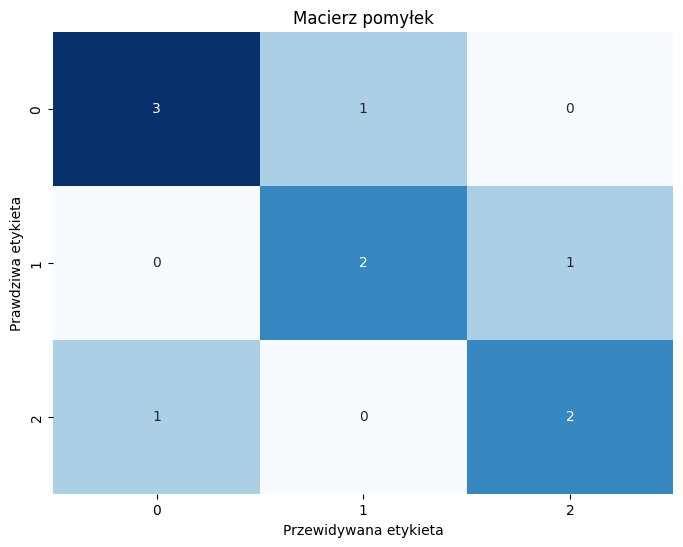

In [12]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_classifier(y_true, y_pred):
    """
    Funkcja do oceny jakości klasyfikatora.

    Parametry:
    y_true: lista lub numpy array, prawdziwe etykiety
    y_pred: lista lub numpy array, przewidywane etykiety

    Zwraca:
    Wydrukowane metryki oceny oraz wyświetloną macierz pomyłek.
    """
    
    # Obliczenie metryk
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Wyświetlenie metryk
    print("Accuracy (Dokładność): {:.2f}%".format(accuracy * 100))
    print("Precision (Precyzja): {:.2f}%".format(precision * 100))
    print("Recall (Czułość): {:.2f}%".format(recall * 100))
    print("F1 Score: {:.2f}%".format(f1 * 100))
    print("\nRaport klasyfikacji:\n")
    print(classification_report(y_true, y_pred))
    
    # Macierz pomyłek
    cm = confusion_matrix(y_true, y_pred)
    
    # Wizualizacja macierzy pomyłek
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Przewidywana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.title('Macierz pomyłek')
    plt.show()

# Przykład użycia

# Zakładając, że masz prawdziwe etykiety i przewidywane etykiety
y_true = np.array([0, 1, 2, 2, 0, 1, 0, 0, 1, 2])
y_pred = np.array([0, 2, 2, 2, 0, 1, 0, 1, 1, 0])

# Ocena klasyfikatora
evaluate_classifier(y_true, y_pred)

In [405]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

clf = RandomForestClassifier(n_estimators=100, max_depth=5, n_jobs=-1)
clf.fit(x_pca, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1)

In [ ]:
clf.predict()